In [8]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import Accuracy

In [9]:
train_dir = 'raf-db-5class\\train'  # Path ke folder train
val_dir = 'raf-db-5class\\test'  # Path ke folder test (validasi)

# Cek struktur dataset
print(f"Train folder contains: {os.listdir(train_dir)}")
print(f"Test folder contains: {os.listdir(val_dir)}")

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'raf-db-5class\\train'

In [ ]:
val_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.5
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(100, 100),
    batch_size = 64,
    shuffle=False,
    class_mode='categorical')

# Analisis distribusi kelas
class_names = list(val_generator.class_indices.keys())

print("\nDistribusi kelas pada data validasi:")
val_labels = val_generator.classes
for label, count in zip(class_names, np.bincount(val_labels)):
    print(f"{label}: {count} sampel")

NameError: name 'ImageDataGenerator' is not defined

In [11]:
# Load the model
model = load_model("model\\5kelas.keras")

# Evaluate the model on the validation set (val_generator)
test_loss, test_acc = model.evaluate(val_generator)

# Print the test accuracy
print(f"Test accuracy: {test_acc:.2f}")


NameError: name 'val_generator' is not defined

45/45 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step


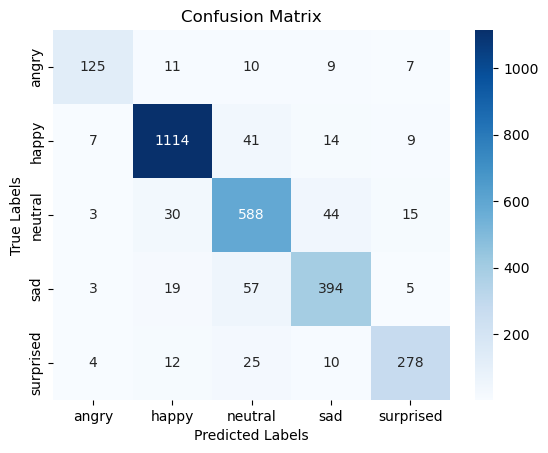

              precision    recall  f1-score   support

       angry       0.88      0.77      0.82       162
       happy       0.94      0.94      0.94      1185
     neutral       0.82      0.86      0.84       680
         sad       0.84      0.82      0.83       478
   surprised       0.89      0.84      0.86       329

    accuracy                           0.88      2834
   macro avg       0.87      0.85      0.86      2834
weighted avg       0.88      0.88      0.88      2834



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Mendapatkan prediksi dari generator validasi
y_true = val_generator.classes  # Label asli
y_pred = model.predict(val_generator)  # Probabilitas prediksi
y_pred_classes = np.argmax(y_pred, axis=1)  # Kelas prediksi

# Menampilkan confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Menampilkan laporan klasifikasi
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print(report)

In [12]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Path ke folder uji
test_folder_path = 'raf-db-happy-sad-angry-neutral\\test\\happy'  # Ganti dengan folder uji Anda

# Mapping indeks ke nama kelas
class_names = ['angry', 'happy', 'neutral', 'sad','surprised']  # Ubah sesuai kelas Anda

# Inisialisasi hitungan untuk setiap kelas
class_counts = {class_name: 0 for class_name in class_names}

# Fungsi untuk memprediksi gambar
def predict_image(image_path):
    image = cv2.imread(image_path)  # Baca gambar
    image_resized = cv2.resize(image, (100, 100))  # Resize ke ukuran input VGG16
    image_array = np.expand_dims(image_resized, axis=0)  # Tambahkan batch dimension
    image_array = image_array / 255.0  # Normalisasi
    predictions = model.predict(image_array, verbose=0)  # Matikan progress bar
    predicted_class = np.argmax(predictions)
    return class_names[predicted_class]

# Iterasi melalui folder
for file_name in os.listdir(test_folder_path):
    file_path = os.path.join(test_folder_path, file_name)
    if os.path.isfile(file_path) and file_name.lower().endswith(('.png', '.jpg', '.jpeg')):  # Cek apakah file adalah gambar
        predicted_emotion = predict_image(file_path)
        class_counts[predicted_emotion] += 1  # Update hitungan untuk kelas yang diprediksi

# Print hasil prediksi untuk setiap kelas
for class_name, count in class_counts.items():
    print(f"Predicted {class_name}: {count}")

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'raf-db-happy-sad-angry-neutral\\test\\happy'

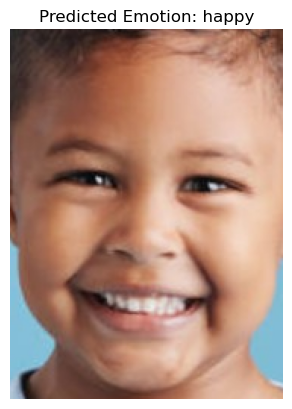

In [19]:
from tensorflow.keras.models import load_model
from mtcnn import MTCNN
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load model yang sudah dilatih
model = load_model("model/5kelas.keras")

image_path = 'image.png'

# Inisialisasi detektor wajah MTCNN
detector = MTCNN()

# Mapping indeks ke nama kelas
class_names = ['angry', 'happy', 'neutral', 'sad', 'surprised']

def detect_and_crop_face(image):
    """
    Fungsi untuk mendeteksi wajah dan meng-crop wajah pertama yang terdeteksi.
    :param image: Input gambar (numpy array)
    :return: Gambar wajah yang ter-crop, atau None jika tidak ada wajah yang terdeteksi
    """
    faces = detector.detect_faces(image)  # Deteksi wajah dalam gambar
    if faces:
        x, y, w, h = faces[0]['box']  # Ambil koordinat wajah pertama
        cropped_face = image[y:y+h, x:x+w]  # Crop wajah dari gambar
        return cropped_face
    else:
        print("No face detected!")
        return None

def predict_image(image_array):
    """
    Fungsi untuk memprediksi emosi dari gambar input.
    :param image_array: Array gambar wajah yang sudah di-crop
    :return: Nama kelas prediksi
    """
    image_resized = cv2.resize(image_array, (100, 100))  # Resize ke ukuran input model
    image_resized = np.expand_dims(image_resized, axis=0)  # Tambahkan dimensi batch
    image_resized = image_resized / 255.0  # Normalisasi gambar
    predictions = model.predict(image_resized, verbose=0)  # Prediksi
    predicted_class = np.argmax(predictions)  # Ambil kelas dengan probabilitas tertinggi
    return class_names[predicted_class]

# Path ke gambar input

# Baca gambar dari file
image = cv2.imread(image_path)

# Convert BGR (OpenCV) ke RGB (matplotlib)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Deteksi dan crop wajah
cropped_face = detect_and_crop_face(image_rgb)

if cropped_face is not None:
    # Prediksi emosi berdasarkan wajah yang di-crop
    predicted_emotion = predict_image(cropped_face)

    # Tampilkan hasil prediksi
    plt.imshow(cropped_face)
    plt.title(f"Predicted Emotion: {predicted_emotion}")
    plt.axis('off')
    plt.show()
else:
    print("Tidak ada wajah yang terdeteksi!")
